In [128]:
import sys
import os

sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject'))

import numpy as np
import torch
from torch import nn
import math

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import spin_system, utils, particles, res_field_algorithm, constants, spectral_integration, mesher, spectra_manager, particles
from visualization import levels_plot, transitions_plot
from population import time_population, tr_utils, transform, mechanisms
import population

from importlib import reload
from spectra_manager import (
    MultiSampleCreator, CoupledSpectraCreatorTimeResolved,
    TruncatedSpectraCreatorTimeResolved, PostSpectraProcessing,TimeResolvedIntensitiesCalculator, ParamSpec
)
from spectral_integration import SpectraIntegratorEasySpinLikeTimeResolved, BaseSpectraIntegrator
import constants

reload(population)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(constants)

reload(mechanisms)

<module 'population.mechanisms' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\population\\mechanisms.py'>

In [129]:
reload(tr_utils)

<module 'population.tr_utils' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\population\\tr_utils.py'>

In [130]:
import typing as tp

mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, np.pi),
                                    initial_grid_frequency=15,
                                    interpolate=False)

def build_powder(mesh, *args) -> spin_system.MultiOrientedSample:
        params = args[0] if len(args) == 1 else args
        g_factor, g_strain, D, D_str, E_D_attitude, h_strain = params

        # g-tensor components
        g_tensor = torch.full((3,), g_factor)
        g_frame = torch.zeros(3)
        g_strain_tensor = torch.full((3,), g_strain)

        # Zero-field splitting calculations
        D_val = 2.0 * D * 1e6
        E_val = 2.0 * D * E_D_attitude * 1e6
        #E_val = -2.0 * E * 1e6
        Dz = 2/3 * D_val
        Dx = -1/3 * D_val - E_val
        Dy = -1/3 * D_val + E_val

        # Strain calculations
        E_str = D_str * E_D_attitude
        #E_str = E_str
        Dx_s = -1/3 * D_str - E_str
        Dy_s = -1/3 * D_str + E_str
        Dz_s = 2/3 * D_str
        strain_e_e = torch.tensor([Dx_s, Dy_s, Dz_s]) \
            * (constants.PLANCK / constants.BOHR) * 1e6

        J = 1.1
        J = 2 * J # Because 2 S1 S2
        J_hz = (J * 100) * 3 * 1e8
        
        components_dipole = torch.tensor([Dx, Dy, Dz]) + J_hz
        d_frame = torch.zeros(3)

        # System construction
        zeem = spin_system.Interaction(g_tensor, g_frame, g_strain_tensor)
        ee_int = spin_system.Interaction(components_dipole, d_frame, strain_e_e)

        e1 = particles.Electron(spin=0.5)
        e2 = particles.Electron(spin=0.5)
        system = spin_system.SpinSystem(
            electrons=[e1, e2],
            g_tensors=[zeem, zeem],
            electron_electron=[(0, 1, ee_int)]
        )

        # Homogeneity strain
        hum_str = 3 * h_strain * torch.ones(3)
        hum_str *= (constants.PLANCK / constants.BOHR) * 4e5
        return spin_system.MultiOrientedSample(system, ham_strain=hum_str, mesh=mesh)
    
    
best_params_cw = {'g_factor': 2.0064026806055115,
 'g_strain': 0.0057826633838925995,
 'D': 88.95762784927365,
 'D_str': 70.71112429094259,
 'E_D_attitude': 0.3327962487663032,
 'h_strain': 8.08377174375672}
best_values_cw = list(best_params_cw.values())

powder_1 = build_powder(mesh, best_values_cw)


best_params_cw = {'g_factor': 2.0014026806055115,
 'g_strain': 0.0057826633838925995,
 'D': 88.95762784927365 / 10,
 'D_str': 70.71112429094259,
 'E_D_attitude': 0.3327962487663032,
 'h_strain': 8.08377174375672}
best_values_cw = list(best_params_cw.values())

powder_2 = build_powder(mesh, best_values_cw)

In [131]:
def build_context_one_sample():
    k_x = 20.3723555477466  * 1.0 
    k_y = 145.4251328218196 * 1.0
    k_z = 8787.46130349088 * 1.0
    triplet_prob = 31.1356746538767
    
    free_probs = [[0.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, triplet_prob, 0.0],
                  [0.0, triplet_prob, 0.0, triplet_prob],
                  [0.0, 0.0, triplet_prob, 0.0]]
    
    free_probs = torch.tensor(free_probs)

    free_probs_tr =[
            [0, k_z, k_y, k_x],
            [k_z, 0, 0.0, 0.0],
            [k_y, 0.0, 0, 0.0],
            [k_x, 0.0, 0.0, 0]
        ]
    
    free_probs_tr = torch.tensor(free_probs_tr)
    
    kynetic_rates = torch.tensor([0.1, 0.01, 0.003, 0.005])
    context = mechanisms.BaseSampleContext(free_probs=free_probs_tr+free_probs)
    
    return context

def build_context():
    sample_contexts = [
        build_context_one_sample(),
        build_context_one_sample()
    ]
    kinetic_rates = [
        torch.tensor([0.1, 0.01, 0.003, 0.005]),
        torch.tensor([0.1, 0.01, 0.003, 0.005])
                    ]
    concentrations = [1.0, 1.0]
    return mechanisms.KineticContext(sample_contexts=sample_contexts, kinetic_rates=kinetic_rates, concentrations=concentrations)

context = build_context()

In [136]:
resonance_frequency = torch.tensor(9.8 * 1e9)
fields_t1 = torch.linspace(0.340, 0.360, 200)

size = 200

t_short = 1.52
t_long = 70.00

t_short_start = torch.tensor(0.15 * 1e-3)
t_long_start =  torch.tensor(6 * 1e-3)

time = torch.linspace(0.0, t_short, size, dtype=torch.float64) * 1e-3

creator_1 = CoupledSpectraCreatorTimeResolved(
    freq=resonance_frequency,
    sample=powder_2
)

creator_2 = CoupledSpectraCreatorTimeResolved(
    freq=resonance_frequency,
    sample=powder_2
)

generators = [mechanisms.ConstTempGeneralMechanism] * 2
kynetic_populator = mechanisms.KineticPopulator(context=context, sample_tr_matrix_generators=generators)

creator_multisamples = MultiSampleCreator(creators = [creator_1, creator_2], weights=[1.0, 1.0], populator=kynetic_populator)

with torch.no_grad():
    fields_t1 = torch.linspace(0.340, 0.360, 100)
    spec = creator_multisamples((powder_1, powder_2), fields_t1, time)

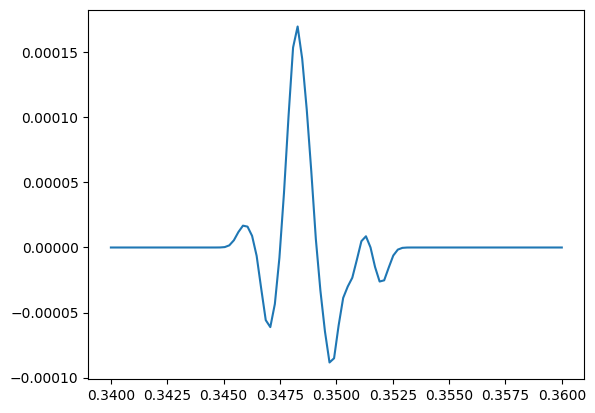

In [142]:
plt.plot(fields_t1.numpy(), spec[0, 22, :].numpy())

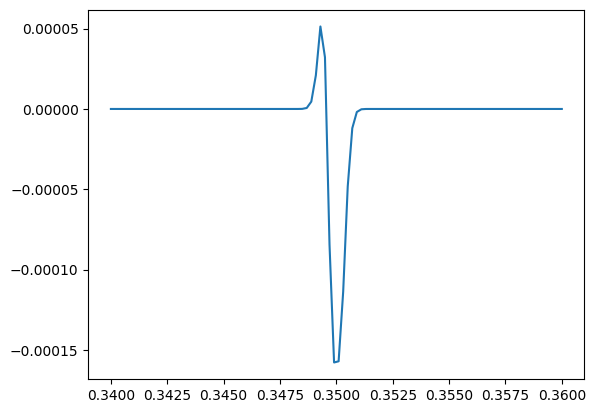

In [143]:
plt.plot(fields_t1.numpy(), spec[1, 22, :].numpy())

In [326]:
with torch.no_grad():
    fields_t1 = torch.linspace(0.340, 0.360, 100)
    spec = creator_multisamples((powder_1, powder_2), resonance_frequency, fields_t1)

C:\Users\User\AppData\Local\Temp\ipykernel_8756\2904658403.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temp = torch.tensor(temp)


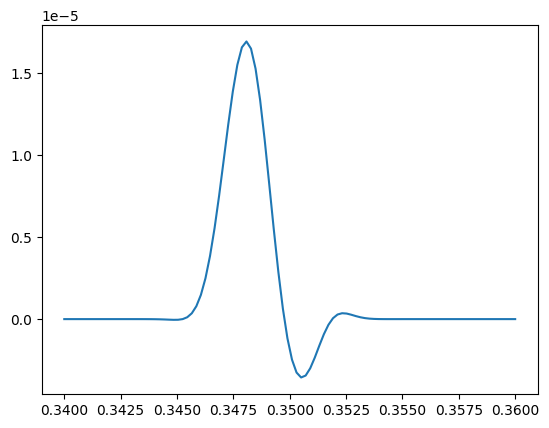

In [317]:
plt.plot(fields_t1.numpy(), spec[0, :, 12].numpy())

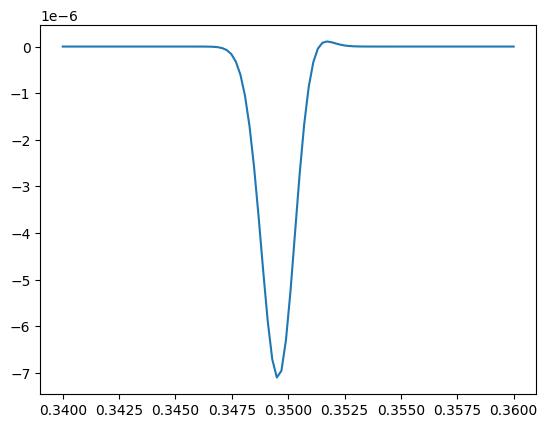

In [318]:
plt.plot(fields_t1.numpy(), spec[1, :, 12].numpy())